## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
import time
import datetime as dt
import urllib.request, json
import os
from pandas_datareader import data
import tweepy
from textblob import TextBlob
import re

Using TensorFlow backend.


## Getting data using Alpha Vantage API

In [2]:
data_source = 'alphavantage'

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '7TONQ8CM5PXZ4YEO'

    # TCS stock market prices
    ticker = "TCS"

    # JSON file with all the stock market data for TCS
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

File already exists. Loading data from CSV


In [3]:
df = pd.read_csv("stock_market_data-TCS.csv")

In [4]:
df = df[['Date', 'Open', 'Close', 'Low', 'High']]

In [5]:
df = df.sort_values('Date')

In [6]:
df.head()

,Date,Open,Close,Low,High
1259,2013-11-01,35.00,36.20,32.100,37.00
1258,2013-11-04,36.80,35.35,34.690,36.80
1257,2013-11-05,35.11,35.35,34.821,35.50
1256,2013-11-06,35.61,35.90,35.610,36.49
1255,2013-11-07,36.80,35.31,34.120,36.80


In [7]:
df.tail()

,Date,Open,Close,Low,High
4,2018-10-26,9.55,9.57,9.32,9.730
3,2018-10-29,9.70,9.69,9.57,9.930
2,2018-10-30,9.65,10.05,9.65,10.080
1,2018-10-31,6.82,5.91,5.72,7.840
0,2018-11-01,6.01,5.39,5.26,6.009


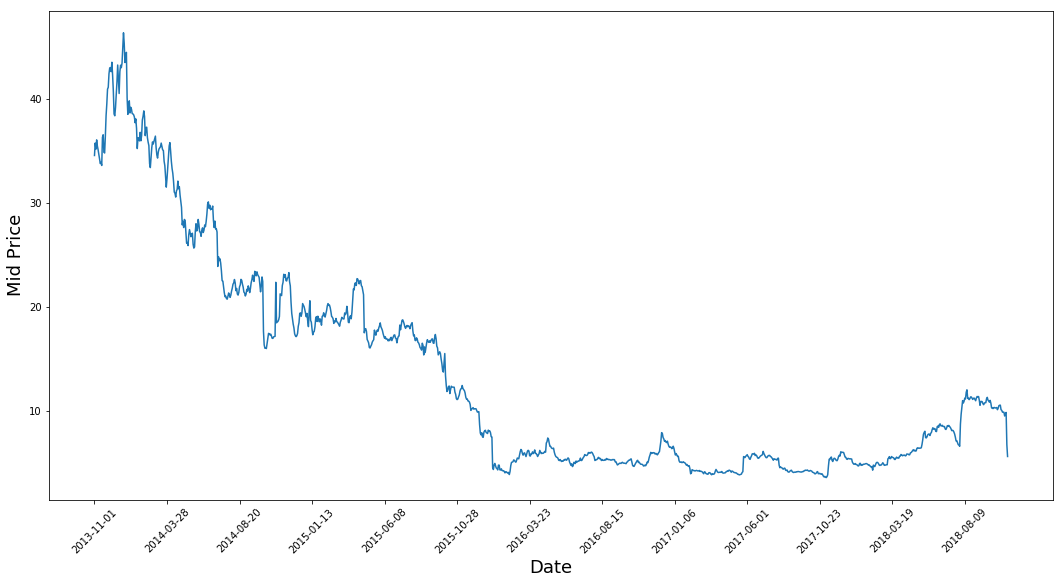

In [8]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],100),df['Date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [9]:
high_prices = df.loc[:,'High']
low_prices = df.loc[:,'Low']
df["Mid Prices"] = (high_prices+low_prices)/2.0

In [10]:
df.head()

,Date,Open,Close,Low,High,Mid Prices
1259,2013-11-01,35.00,36.20,32.100,37.00,34.5500
1258,2013-11-04,36.80,35.35,34.690,36.80,35.7450
1257,2013-11-05,35.11,35.35,34.821,35.50,35.1605
1256,2013-11-06,35.61,35.90,35.610,36.49,36.0500
1255,2013-11-07,36.80,35.31,34.120,36.80,35.4600


In [11]:
df.tail()

,Date,Open,Close,Low,High,Mid Prices
4,2018-10-26,9.55,9.57,9.32,9.730,9.5250
3,2018-10-29,9.70,9.69,9.57,9.930,9.7500
2,2018-10-30,9.65,10.05,9.65,10.080,9.8650
1,2018-10-31,6.82,5.91,5.72,7.840,6.7800
0,2018-11-01,6.01,5.39,5.26,6.009,5.6345


## Data Cleaning

In [11]:
df.drop("Date", axis = 1,inplace = True)

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()
scaler.fit(df)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [14]:
df = scaler.transform(df)

## Building Long-Short Term Memory Cell to implement Recurrent Neural Network

![title](img/RNN.png)

![title](img/LSTM.png)

In [15]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(None, layers[0]),
        units=50,
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        100,
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        units=1))
    model.add(Activation('linear'))

    start = time.time()
    model.compile(loss='mse', optimizer='rmsprop')
    print ('compilation time : ', time.time() - start)
    return model

## Load data as per model requirements

In [16]:
def load_data(stock, seq_len):
    amount_of_features = 5
    data = stock
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result =  np.array(result)
    row = round(0.75 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [17]:
window = 5
X_train, y_train, X_test, y_test = load_data(df, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (940, 5, 5)
y_train (940,)
X_test (314, 5, 5)
y_test (314,)


In [18]:
model = build_model([5,window,1])

compilation time :  0.02281332015991211


## Training Time!

In [19]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=30,
    validation_split=0.1,
    verbose=1)

Train on 846 samples, validate on 94 samples
Epoch 1/30
846/846 [==============================] - 1s 2ms/step - loss: 0.9017 - val_loss: 0.2787
Epoch 2/30
846/846 [==============================] - 0s 132us/step - loss: 0.2839 - val_loss: 0.1093
Epoch 3/30
846/846 [==============================] - 0s 118us/step - loss: 0.0636 - val_loss: 0.0564
Epoch 4/30
846/846 [==============================] - 0s 120us/step - loss: 0.0418 - val_loss: 0.0276
Epoch 5/30
846/846 [==============================] - 0s 123us/step - loss: 0.0331 - val_loss: 0.0138
Epoch 6/30
846/846 [==============================] - 0s 119us/step - loss: 0.0273 - val_loss: 0.0066
Epoch 7/30
846/846 [==============================] - 0s 119us/step - loss: 0.0248 - val_loss: 0.0039
Epoch 8/30
846/846 [==============================] - 0s 117us/step - loss: 0.0251 - val_loss: 0.0031
Epoch 9/30
846/846 [==============================] - 0s 137us/step - loss: 0.0256 - val_loss: 0.0029
Epoch 10/30
846/846 [==================

In [20]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print(trainScore)

0.014827937394643123


In [21]:
accuracy = (1-trainScore)*100

## Predictions

In [23]:
p = model.predict(X_test)

In [24]:
from sklearn.metrics import mean_squared_error

In [25]:
mse = mean_squared_error(y_test, p)

In [26]:
accuracy_test = (1-mse)*100

## Visualizations

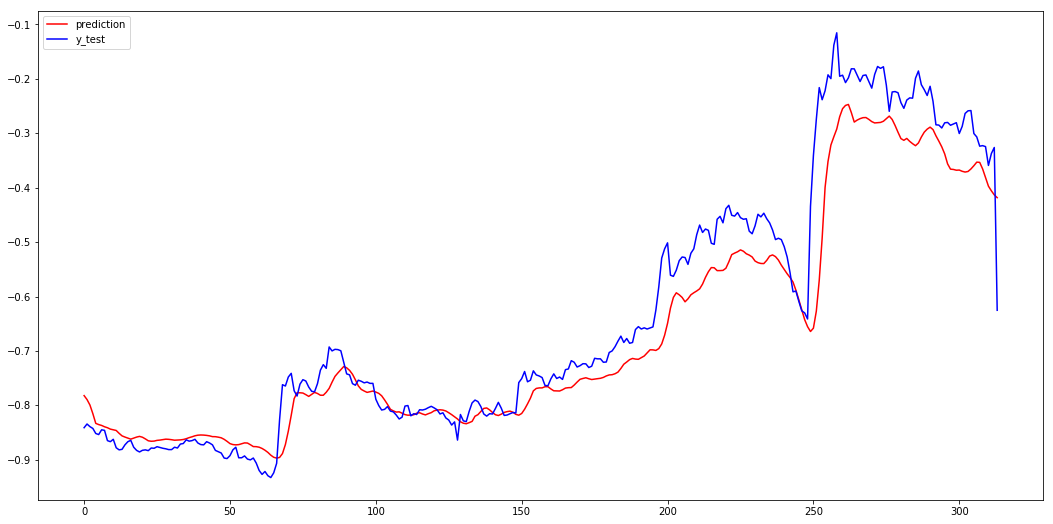

In [28]:
import matplotlib.pyplot as plt2
plt2.figure(figsize = (18,9))
plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()

## Sentiment Analysis

In [29]:
consumer_key= 'E0pFYVai9VaOhqLiRBEC6gpGF'
consumer_secret= 'XAMh4l9XL5nwFK3MN5tAjtXA2YgDN1tw5f7L2n6dz5ib8VYlbm'

access_token='3261604734-86c7DOJP98GwNeFWzvgPQKFUTyHn1ZFwlloJP3v'
access_token_secret='eXEmlEAdxaFjueVP03jsAWeOeNMkI7ToiDQkyvLDa6eX7'

In [30]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [31]:
public_tweets = api.search('TCS', count = 1000)

In [32]:
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [33]:
def get_tweet_sentiment(tweet):
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

In [34]:
positive = 0
negative = 0
neutral = 0
print(len(public_tweets))
for tweet in public_tweets:
#     print(tweet.text)
    print(clean_tweet(tweet.text))
    sentiment = get_tweet_sentiment(tweet.text) 
    print(sentiment)
    if sentiment == 'positive':
        positive += 1
    elif sentiment == 'negative':
        negative += 1
    elif sentiment == 'neutral':
        neutral += 1
    print("")

100
RT HappyHalloween For your chance to WIN this spook tacular bundle on this wicked WinItWednesday simply FOLLOW us and RT
positive

RT TCS makes first digital acquisition buys design studio W12 Technology News ETtech
positive

TCS makes its first digital acquisition all you need to know about TCS buyout of London s W12 Studio
positive

Stocks Radar Axis Bank Hindustan Petroleum Indraprastha Gas TCS
neutral

RT PLANNING YOUR RACE DAY OUTFIT Include our LovePartiesHateWhips accessories and share your pic with the LovePartiesHateWhips h
neutral

Se algu m que voc n o conhece lhe diz oi o que voc diz Oi
neutral

RT RT this post and follow us for your chance to twirl into winter and win a Ballet Theatre and Ice Skating Friends We ve g
positive

RT
neutral

Tcs acusa Bolsonaro de ditador fascista e agora o Bolsonaro chama um magistrado reconhecendo as
neutral

molliebanks 21
neutral

RT esports One of the worse goal I scored but the most satisfying to watch on stream Laughed way t
positiv

In [35]:
print('Positive:', positive)
print('Negative:', negative)
print('Neutral:', neutral)

Positive: 44
Negative: 6
Neutral: 50
